# Case_study_3_2

Implement ISTA and FISTA and compare with subgradient implementations for solving LASSO regression

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
from local.lib.utils import plot_surface, solver_cvx, eval_loss, ista_lasso, fista_lasso, grad_FOM, grad_FOM_decay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

In [2]:
# Loading scenarios
# ===========================
scenario=2;
data_class, set_up = scenarios_regression(scenario);

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L1 = lambda w: cp.pnorm(w, p=1)
loss_lasso = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + lambd * reg_L1(w)

subgrad_lasso = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y)+lambd*np.sign(w)
grad_LS = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y);


# Solution of the empirical risk using CVX
#=========================================
w_lasso_cvx=solver_cvx(set_up,loss_lasso)

w = cp.Variable(w_lasso_cvx.shape[0])
w.value = w_lasso_cvx 
loss_opt=loss_lasso(set_up['Niter_train'],set_up['Xtrain'][:,:set_up['d']+1],set_up['ytrain'][:,0],w,set_up['Lambda']).value

# Gradient descent
out_subgd =grad_FOM(set_up,subgrad_lasso)
out_subgd_decay =grad_FOM_decay(set_up,subgrad_lasso)

loss_subgrad=eval_loss(out_subgd,set_up,loss_lasso)
loss_subgrad_decay=eval_loss(out_subgd_decay,set_up,loss_lasso)

out_ista=ista_lasso(set_up,grad_LS)
out_fista=fista_lasso(set_up,grad_LS)

loss_ista=eval_loss(out_ista,set_up,loss_lasso)
loss_fista=eval_loss(out_fista,set_up,loss_lasso)

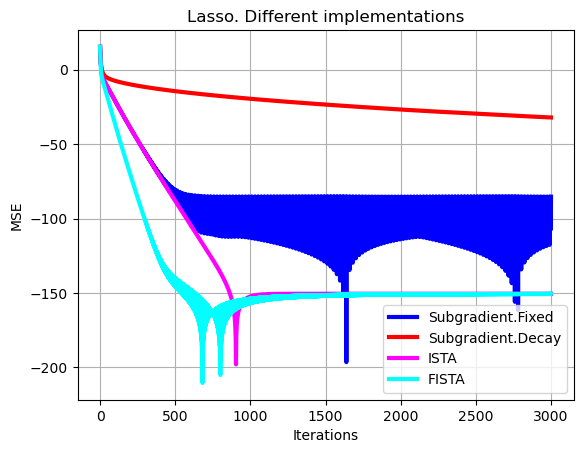

In [3]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3, label = 'Subgradient.Fixed')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad_decay-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3, label = 'Subgradient.Decay')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_ista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='magenta', linewidth = 3, label = 'ISTA')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_fista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='cyan', linewidth = 3, label = 'FISTA')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('Lasso. Different implementations')
plt.savefig('pw_lasso.png',dpi=300)
plt.show()